In [81]:
import sys
if not '..' in sys.path:
    sys.path.append('..')
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colormaps
from analysis import collection, analysis, emg
from analysis import plot as analysis_plot
import scipy as sp
import pandas as pd
from sklearn.mixture import BayesianGaussianMixture
from sklearn.base import clone
import seaborn as sns
import pickle
from scipy.stats import multivariate_normal

%matplotlib inline

In [2]:
with open('olympics_subjects.pkl', 'rb') as handle:
    subjects = pickle.load(handle)
len(subjects)

46

In [82]:
def gaussian_entropy(cov):
    # https://gregorygundersen.com/blog/2020/09/01/gaussian-entropy/
    assert cov.shape == (64,64)
    # (D/2)*(1 + log(2pi)) + (1/2)*log(det(C))
    return 32*(1 + np.log(2*np.pi)) + 0.5*np.log(np.linalg.det(cov))

def total_gmm_entropy(model):
    assert len(model.covariances_) > 0
    return np.sum([gaussian_entropy(c)*w for c, w in zip(model.covariances_,model.weights_)])

In [106]:
def load_log_trial_models(subject_idx):
    with open(f"gmm_models_log_trial/subject_{subject_idx}.pkl","rb") as handle:
        return pickle.load(handle)

def load_trial_models(subject_idx):
    with open(f"gmm_models_trial/subject_{subject_idx}.pkl","rb") as handle:
        return pickle.load(handle)
    
def load_log_calibration_models(subject_idx):
    with open(f"gmm_models_log_calibration/subject_{subject_idx}.pkl","rb") as handle:
        return pickle.load(handle)

def load_log_movement_models(subject_idx):
    with open(f"gmm_models_log_movement/subject_{subject_idx}.pkl","rb") as handle:
        return pickle.load(handle)

In [107]:
model_entropies = []
for subject_idx in range(len(subjects)):
    log_models = load_log_trial_models(subject_idx)
    model_entropies.append([total_gmm_entropy(model) for model in log_models])

calibration_entropies = []
for subject_idx in range(len(subjects)):
    log_calibration_model = load_log_calibration_models(subject_idx)[0]
    calibration_entropies.append(total_gmm_entropy(log_calibration_model))

movement_entropies = []
for subject_idx in range(len(subjects)):
    log_movement_model = load_log_movement_models(subject_idx)[0]
    movement_entropies.append(total_gmm_entropy(log_movement_model))

In [108]:
reward_df = pd.read_pickle("trajectory_dataframe.pkl")
mean_rewards = reward_df.groupby(level=["subject"]).mean()["reward"]**-1
mean_rewards.shape

(46,)

In [109]:
def linear_fit(x_data, y_data):
    result = sp.stats.linregress(x_data, y_data)
    return result

def plot_linear_fit(x, result, ax):
    ax.plot(x, result.intercept + result.slope*x,"--", color="tab:red", label=f"Linear Fit, $R^2$={np.round(result.rvalue**2, 5)}")

def linspace(data):
    return np.linspace(np.min(data),np.max(data),100,endpoint=True)

### higher entropy -- more equiprobable outcomes || lower entropy -- less equiprobable outcomes

goes to negative infinity -- meaning delta function, complete information about the outcome!

39.81522942312132


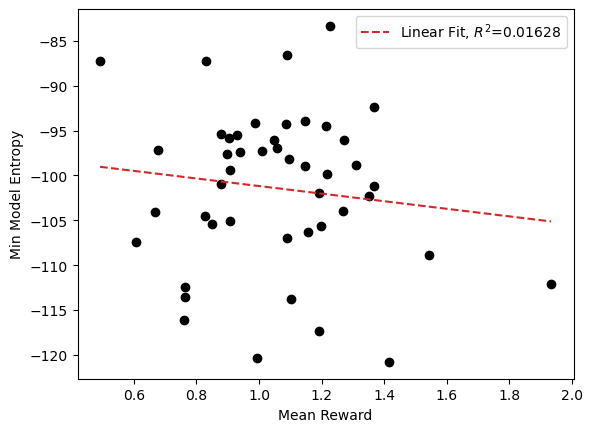

In [110]:
plt.figure()
first_model_entropies = [np.min(m) for m in model_entropies]
plt.plot(mean_rewards,first_model_entropies,"ko")
res = linear_fit(mean_rewards,first_model_entropies)
x = np.linspace(mean_rewards.min(),mean_rewards.max(),100,endpoint=True)
plot_linear_fit(x,res,plt.gca())
plt.legend()
plt.ylabel("Min Model Entropy")
plt.xlabel("Mean Reward")
print(res.pvalue*100)

0.6145637584075447


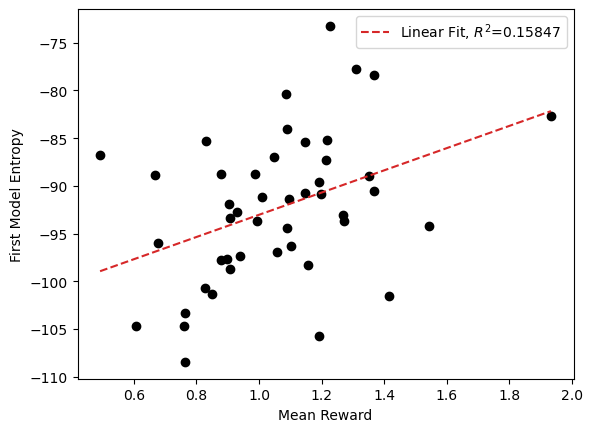

In [111]:
plt.figure()
first_model_entropies = [m[0] for m in model_entropies]
plt.plot(mean_rewards,first_model_entropies,"ko")
res = linear_fit(mean_rewards,first_model_entropies)
x = np.linspace(mean_rewards.min(),mean_rewards.max(),100,endpoint=True)
plot_linear_fit(x,res,plt.gca())
plt.legend()
plt.ylabel("First Model Entropy")
plt.xlabel("Mean Reward")
print(res.pvalue*100)

32.404883515535545


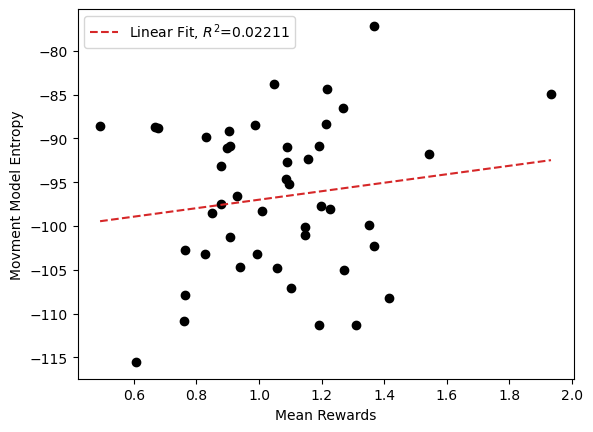

In [112]:
plt.figure()
plt.plot(mean_rewards,movement_entropies,"ko")
res = linear_fit(mean_rewards,movement_entropies)
x = np.linspace(min(mean_rewards),max(mean_rewards),100,endpoint=True)
plot_linear_fit(x,res,plt.gca())
plt.legend()
plt.ylabel("Movment Model Entropy")
plt.xlabel("Mean Rewards")
print(res.pvalue*100)

0.1637695850647448


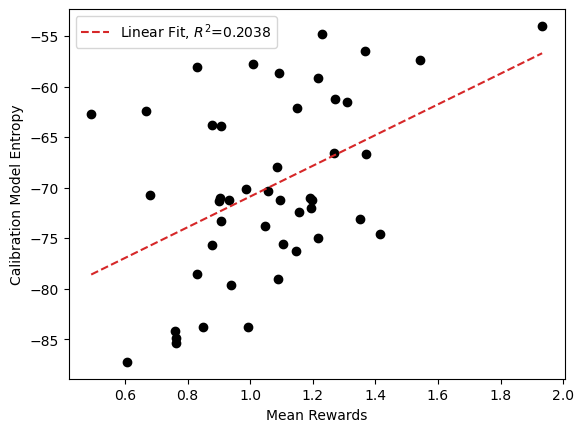

In [105]:
plt.figure()
plt.plot(mean_rewards,calibration_entropies,"ko")
res = linear_fit(mean_rewards,calibration_entropies)
x = np.linspace(min(mean_rewards),max(mean_rewards),100,endpoint=True)
plot_linear_fit(x,res,plt.gca())
plt.legend()
plt.ylabel("Calibration Model Entropy")
plt.xlabel("Mean Rewards")
print(res.pvalue*100)

0.02044883009230521


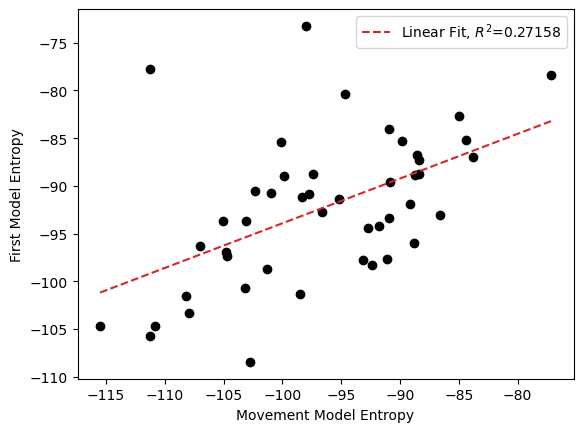

In [114]:
plt.figure()
first_model_entropies = [m[0] for m in model_entropies]
plt.plot(movement_entropies,first_model_entropies,"ko")
res = linear_fit(movement_entropies,first_model_entropies)
x = np.linspace(min(movement_entropies),max(movement_entropies),100,endpoint=True)
plot_linear_fit(x,res,plt.gca())
plt.legend()
plt.ylabel("First Model Entropy")
plt.xlabel("Movement Model Entropy")
print(res.pvalue*100)

1.5582248496099332e-06


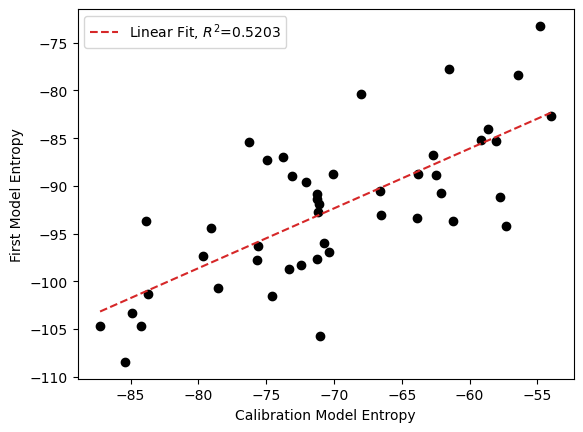

In [89]:
plt.figure()
first_model_entropies = [m[0] for m in model_entropies]
plt.plot(calibration_entropies,first_model_entropies,"ko")
res = linear_fit(calibration_entropies,first_model_entropies)
x = np.linspace(min(calibration_entropies),max(calibration_entropies),100,endpoint=True)
plot_linear_fit(x,res,plt.gca())
plt.legend()
plt.ylabel("First Model Entropy")
plt.xlabel("Calibration Model Entropy")
print(res.pvalue*100)

0.04842310919963539


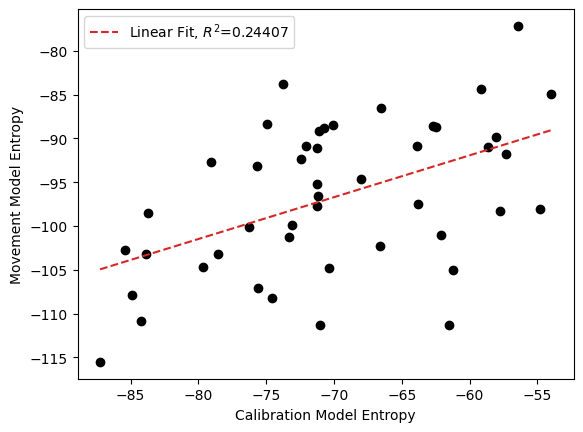

In [115]:
plt.figure()
plt.plot(calibration_entropies,movement_entropies,"ko")
res = linear_fit(calibration_entropies,movement_entropies)
x = np.linspace(min(calibration_entropies),max(calibration_entropies),100,endpoint=True)
plot_linear_fit(x,res,plt.gca())
plt.legend()
plt.ylabel("Movement Model Entropy")
plt.xlabel("Calibration Model Entropy")
print(res.pvalue*100)

0.0002504210554321997


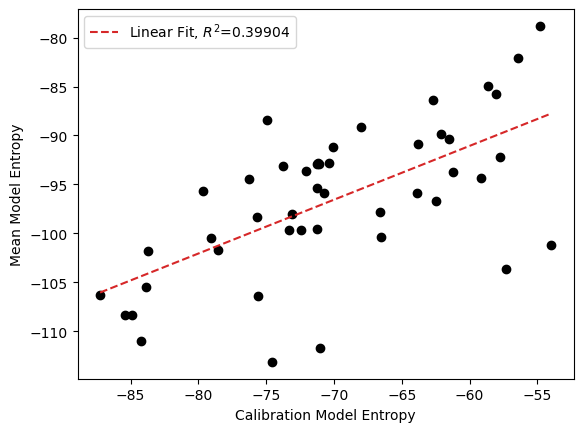

In [90]:
plt.figure()
first_model_entropies = [np.mean(m) for m in model_entropies]
plt.plot(calibration_entropies,first_model_entropies,"ko")
res = linear_fit(calibration_entropies,first_model_entropies)
x = np.linspace(min(calibration_entropies),max(calibration_entropies),100,endpoint=True)
plot_linear_fit(x,res,plt.gca())
plt.legend()
plt.ylabel("Mean Model Entropy")
plt.xlabel("Calibration Model Entropy")
print(res.pvalue*100)

0.0004607311510713351


Text(0.5, 0, 'Mean Rewards')

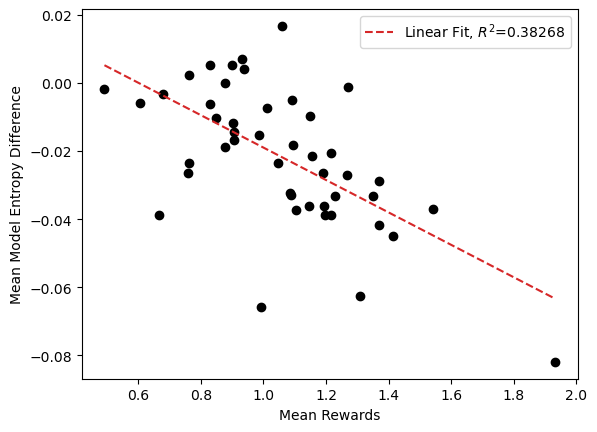

In [130]:
entropy_mean_diffs = []
stop_idx = []
for i, e in enumerate(model_entropies):
    if not i in stop_idx:
        e = np.array(e)
        # percent difference -- (x2 - x1)/x1
        entropy_mean_diffs.append(np.mean([(e[i+1]-e[i])/np.abs(e[i]) for i in range(4)]))
        # entropy_mean_diffs.append(np.mean([(e[i+1]-e[i])/np.abs(e[i]) for i in range(e.shape[0]-1)]))
rewards = np.array([m for i, m in enumerate(mean_rewards) if not i in stop_idx])
plt.plot(rewards, entropy_mean_diffs, 'ko')
res = linear_fit(rewards,entropy_mean_diffs)
x = np.linspace(rewards.min(),rewards.max(),100,endpoint=True)
plot_linear_fit(x,res,plt.gca())
plt.legend()
print(res.pvalue*100)
plt.ylabel("Mean Model Entropy Difference")
plt.xlabel("Mean Rewards")